In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List
import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import StepLR
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

In [3]:
from src import train, utils
from src import calculus as calc
import src.data.aquarium_domain as aq
from src.models.mlp_model import MLPModel

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
NU = 0.001
U_MAX = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

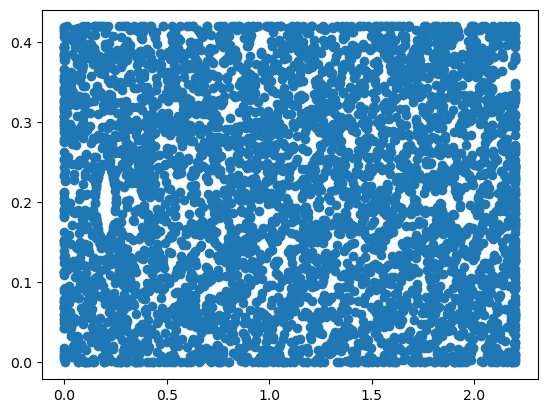

In [6]:
domain_ctx = aq.AquariumContext(
    dim=2,
    l_bounds=[0, 0],
    u_bounds=[2.2, 0.42],
    N_int=4_000,
    N_sides=[(100, 100), (100, 100)],
    device=device,
    ball_centre=torch.tensor([0.2, 0.2], device=device),
    ball_r=0.05
)

domain = aq.AquariumDomain(domain_ctx)
domain.generate_points()
utils.plot_domain(domain)

In [7]:
#TODO: vymyslet lepsi system pro derivace

def loss_fn(model: torch.nn.Module, domain: aq.AquariumDomain) -> torch.Tensor:
    # ztrata na vnitrku
    psi, p, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y = calc.compute_derivatives_ns(model, domain.interior)
    inner_loss_1 = torch.mean((-NU * (u_xx + u_yy) + u * u_x + v * u_y + p_x)**2)
    inner_loss_2 = torch.mean((-NU * (v_xx + v_yy) + u * v_x + v * v_y + p_y)**2)
    inner_loss = inner_loss_1 + inner_loss_2

    print(torch.cat((u_xx + u_yy, v_xx + v_yy), dim=1))

    # ztrata na leve hranici: x=0
    _, v_left, u_left = calc.compute_derivatives_2d(model, domain.sides[0][0], 0)

    inflow = 4 * U_MAX * domain.sides[0][0][:, 1:2] * (domain.ctx.u_bounds[1] - domain.sides[0][0][:, 1:2]) / (domain.ctx.u_bounds[1]**2)
    left_loss = torch.mean((u_left - inflow)**2 + v_left**2)

    # ztrata na prave hranici: x=2.2
    in_right = domain.sides[0][1].requires_grad_(True)
    out_right = model(in_right)
    psi_right, p_right = out_right[:, 0], out_right[:, 1]
    psi_right_grad = grad(psi_right, in_right, torch.ones_like(psi_right), create_graph=True)[0]
    v_right, u_right = -psi_right_grad[:, 0:1], psi_right_grad[:, 1:2]
    v_right_x = grad(v_right, in_right, torch.ones_like(v_right), create_graph=True)[0][:, 0:1]
    u_right_x = grad(u_right, in_right, torch.ones_like(u_right), create_graph=True)[0][:, 0:1]

    right_loss = torch.mean((NU * u_right_x - p_right)**2 + v_right_x**2)

    # ztrata na horni hranici: y=0.42
    _, v_top, u_top = calc.compute_derivatives_2d(model, domain.sides[1][1], 0)
    top_loss = torch.mean(v_top**2 + u_top**2)

    # ztrata na dolni hranici: y=0
    _, v_bottom, u_bottom = calc.compute_derivatives_2d(model, domain.sides[1][0], 0)
    bottom_loss = torch.mean(v_bottom**2 + u_bottom**2)

    # ztrata na kouli
    _, v_ball, u_ball = calc.compute_derivatives_2d(model, domain.ball_boundary, 0)
    ball_loss = torch.mean(v_ball**2 + u_ball**2)

    total_loss = inner_loss + left_loss + right_loss + top_loss + bottom_loss + ball_loss
    return total_loss

def loss_fn_ref(model: torch.nn.Module, domain: aq.AquariumDomain) -> torch.Tensor:
    # ztrata na vnitrku
    psi, p, u, v, u_x, u_y, v_x, v_y, u_xx, u_yy, v_xx, v_yy, p_x, p_y = calc.compute_derivatives_ns(model, domain.interior)
    inner_loss_1 = torch.mean((-NU * (u_xx + u_yy) + u * u_x + v * u_y + p_x)**2)
    inner_loss_2 = torch.mean((-NU * (v_xx + v_yy) + u * v_x + v * v_y + p_y)**2)
    inner_loss = inner_loss_1 + inner_loss_2

    # ztrata na leve hranici
    in_left = domain.left_boundary.requires_grad_(True)
    out_left = model(in_left)
    psi_left = out_left[:, 0]
    psi_left_grad = grad(psi_left, in_left, torch.ones_like(psi_left), create_graph=True)[0]
    v_left, u_left = -psi_left_grad[:, 0:1], psi_left_grad[:, 1:2]

    inflow = 4 * U_MAX * in_left[:, 1:2] * (domain.cfg.y_1 - in_left[:, 1:2]) / (domain.cfg.y_1**2)
    left_loss = torch.mean((u_left - inflow)**2 + (v_left)**2)

    # ztrata na prave hranici
    in_right = domain.right_boundary.requires_grad_(True)
    out_right = model(in_right)
    psi_right, p_right = out_right[:, 0], out_right[:, 1]
    psi_right_grad = grad(psi_right, in_right, torch.ones_like(psi_right), create_graph=True)[0]
    v_right, u_right = -psi_right_grad[:, 0:1], psi_right_grad[:, 1:2]
    v_right_x = grad(v_right, in_right, torch.ones_like(v_right), create_graph=True)[0][:, 0:1]
    u_right_x = grad(u_right, in_right, torch.ones_like(u_right), create_graph=True)[0][:, 0:1]

    right_loss = torch.mean((NU * u_right_x - p_right)**2) + torch.mean((v_right_x)**2)

    # ztrata na horni hranici
    in_top = domain.top_boundary.requires_grad_(True)
    out_top = model(in_top)
    psi_top = out_top[:, 0]
    psi_top_grad = grad(psi_top, in_top, torch.ones_like(psi_top), create_graph=True)[0]
    v_top, u_top = -psi_top_grad[:, 0:1], psi_top_grad[:, 1:2]

    top_loss = torch.mean((v_top)**2 + (u_top)**2)

    # ztrata na dolni hranici
    in_bottom = domain.bottom_boundary.requires_grad_(True)
    out_bottom = model(in_bottom)
    psi_bottom = out_bottom[:, 0]
    psi_bottom_grad = grad(psi_bottom, in_bottom, torch.ones_like(psi_bottom), create_graph=True)[0]
    v_bottom, u_bottom = -psi_bottom_grad[:, 0:1], psi_bottom_grad[:, 1:2]

    bottom_loss = torch.mean((v_bottom)**2 + (u_bottom)**2)

    # ztrata na kouli
    in_ball = domain.ball_boundary.requires_grad_(True)
    out_ball = model(in_ball)
    psi_ball = out_ball[:, 0]
    psi_ball_grad = grad(psi_ball, in_ball, torch.ones_like(psi_ball), create_graph=True)[0]
    v_ball, u_ball = -psi_ball_grad[:, 0:1], psi_ball_grad[:, 1:2]

    ball_loss = torch.mean((v_ball)**2 + (u_ball)**2)

    total_loss = inner_loss + left_loss + right_loss + top_loss + bottom_loss + ball_loss
    return total_loss

In [8]:
def int_residuum(input: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    output = model(input)
    u, p = output[:, :-1], output[:, -1:]
    residuum = calc.material_derivative(input, u, device=device, time_dependant=False) +\
               calc.nabla(input, p, retain=True) - NU * calc.laplacian(input, u, device=device, time_dependant=False)
    return residuum

def new_loss(model: torch.nn.Module, domain: aq.AquariumDomain) -> torch.Tensor:
    # ztrata na vnitrku
    interior = domain.interior.requires_grad_(True)
    int_res = int_residuum(interior, model)
    inner_loss = torch.mean(int_res[:, 0:1]**2) + torch.mean(int_res[:, 1:2]**2)
    
    # ztrata na leve hranici
    input_left = domain.sides[0][0]
    output_left = model(input_left)
    u_left = output_left[:, :-1]
    inflow = 4 * U_MAX * input_left[:, 1:2] * (domain.ctx.u_bounds[1] - input_left[:, 1:2]) / (domain.ctx.u_bounds[1]**2)
    left_loss = torch.mean((u_left[:, 0:1] - inflow)**2 + u_left[:, 1:2]**2)
    
    # ztrata na prave hranici
    input_right = domain.sides[0][1].requires_grad_(True)
    output_right = model(input_right)
    u_right, p_right = output_right[:, :-1], output_right[:, -1:]
   # print(u_right, p_right)
    u_right_x = grad(u_right[:, 0:1], input_right, torch.ones_like(u_right[:, 0:1]), create_graph=True)[0][:, 0:1]
    v_right_x = grad(u_right[:, 1:2], input_right, torch.ones_like(u_right[:, 1:2]), create_graph=True)[0][:, 0:1]
    right_loss = torch.mean((NU * u_right_x - p_right)**2 + v_right_x**2)
   # print(u_right_x, v_right_x)

    # ztrata na horni hranici
    U_top = model(domain.sides[1][1])
    top_loss = torch.mean(U_top[:, 0:1]**2 + U_top[:, 1:2]**2)

    # ztrata na dolni hranici
    U_bottom = model(domain.sides[1][0])
    bottom_loss = torch.mean(U_bottom[:, 0:1]**2 + U_bottom[:, 1:2]**2)

    # ztrata na kouli
    U_ball = model(domain.ball_boundary)
    ball_loss = torch.mean(U_ball[:, 0:1]**2 + U_ball[:, 1:2]**2)

    total_loss = inner_loss + left_loss + right_loss + top_loss + bottom_loss + ball_loss
    return total_loss

In [9]:
model = MLPModel(2, 3, [64, 64, 64, 64], domain_ctx.u_bounds, domain_ctx.l_bounds).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, 5_000, 0.5)

In [10]:
inter_pts = domain.interior.requires_grad_(True)
res = new_loss(model, domain)

In [11]:
context = train.TrainingContext(
    model=model,
    domain=domain,
    optimizer=optimizer,
    loss_fn=new_loss,
    scheduler=scheduler,
    epochs=1_500,
    monitor_gradient=True,
)

loss_values = train.train_switch_to_lbfgs(context)

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Loss at epoch 1 is: 0.053043581545352936. Total gradient norm: 0.6730676316730386 


KeyboardInterrupt: 

In [12]:
# vykresleni vyvoje ztraty
utils.plot_loss_values(loss_values, 'Epochs', 'Loss')

NameError: name 'loss_values' is not defined

/home/berva/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


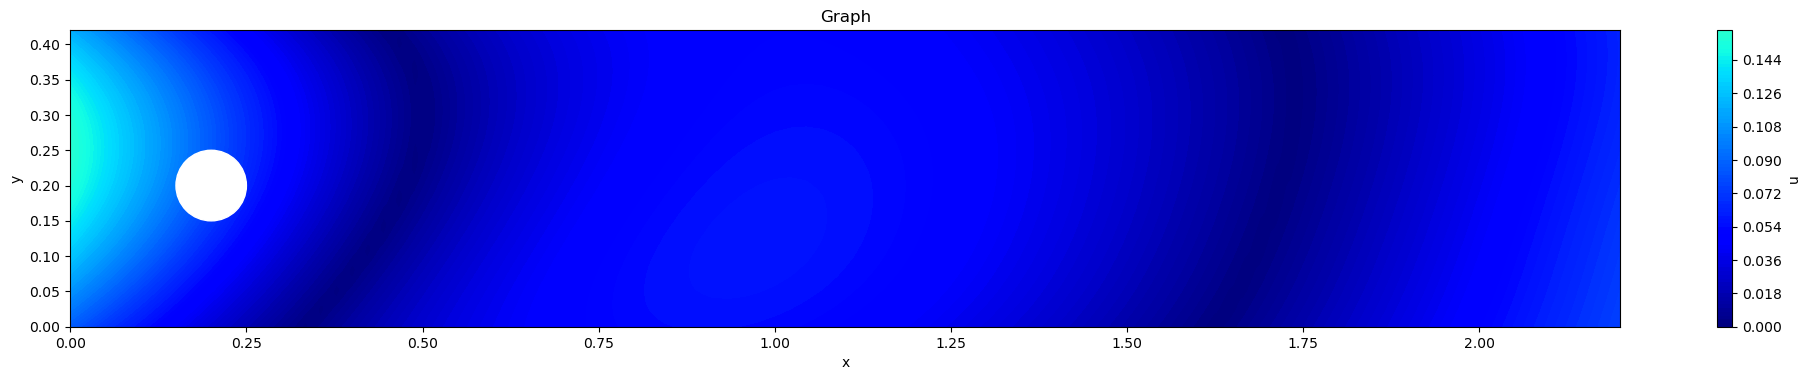

In [13]:
# vykresleni rychlosti kapaliny

def u(x: torch.Tensor):
    with torch.no_grad():
        u = model(x)[:, :-1]

    return torch.sqrt(u[:, 0:1]**2 + u[:, 1:2]**2)

plot_context = utils.PlotContext(
    u_bounds=domain_ctx.u_bounds,
    l_bounds=domain_ctx.l_bounds,
    figsize=(25,3.85),
    patches=[plt.Circle((0.2, 0.2), 0.05, color="white", zorder=10)],
    device=device,
    vmin=0.0,
    vmax=0.4,
    N=100
)

utils.plot_function_on_2d_cube(u, plot_context)